# CIFAR-10 classification

In [1]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import LeakyReLU
from keras import backend as K
from keras.callbacks import ReduceLROnPlateau
import numpy as np
import math
from math import ceil
import matplotlib.pyplot as plt 
import os
import pandas as pd
from sklearn import metrics
from sklearn.metrics import classification_report
import seaborn as sns
import tensorflow as tf 

#x_train = x_train.astype('float32')
#x_test = x_test.astype('float32')
#x_train /= 255
#x_test /= 255

Using TensorFlow backend.


# Data reading

## Defining constants

In [2]:
LABELS= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
batch_size = 100
num_classes = 10
epochs = 50
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

## Reading the data

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

## Creating a model

In [5]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(LeakyReLU(alpha=0.3))
model.add(Conv2D(32, (3, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(LeakyReLU(alpha=0.3))
model.add(Conv2D(64, (3, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 15, 15, 64)       

## Setting the optimizer and compilation of a model

In [6]:
opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [7]:
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        zca_epsilon=1e-06,
        rotation_range=0,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.,
        zoom_range=0.,
        channel_shift_range=0.,
        fill_mode='nearest',
        cval=0., 
        horizontal_flip=True,
        vertical_flip=False, 
        rescale=None,
        preprocessing_function=None,
        data_format=None,
        validation_split=0.0)

    datagen.fit(x_train)

    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=4)

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Using real-time data augmentation.
Epoch 1/50
500/500 [==============================] - 116s 233ms/step - loss: 10.8014 - accuracy: 0.2391 - val_loss: 2.1464 - val_accuracy: 0.3835
Epoch 2/50
500/500 [==============================] - 116s 232ms/step - loss: 2.5042 - accuracy: 0.3121 - val_loss: 1.5933 - val_accuracy: 0.4502
Epoch 3/50
500/500 [==============================] - 115s 229ms/step - loss: 1.9705 - accuracy: 0.3584 - val_loss: 1.5638 - val_accuracy: 0.4599
Epoch 4/50
500/500 [==============================] - 113s 226ms/step - loss: 1.7692 - accuracy: 0.3999 - val_loss: 1.4156 - val_accuracy: 0.5100
Epoch 5/50
500/500 [==============================] - 114s 227ms/step - loss: 1.6544 - accuracy: 0.4341 - val_loss: 1.4269 - val_accuracy: 0.5062
Epoch 6/50
500/500 [==============================] - 115s 230ms/step - loss: 1.5801 - accuracy: 0.4551 - val_loss: 1.3352 - val_accuracy: 0.5427
Epoch 7/50
500/500 [==============================] - 115s 229ms/step - loss: 1.5196 - a

# Results

In [8]:
def show_confusion_matrix(validations, predictions, num_classes):
    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(num_classes, num_classes))
    hm = sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.yticks(rotation = 0) 
    hm.invert_yaxis()
    hm.set_ylim(0, len(matrix))
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

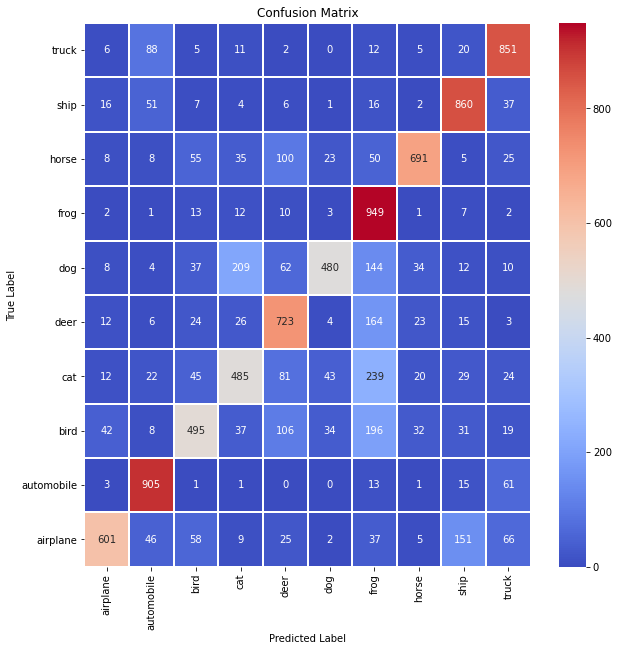

              precision    recall  f1-score   support

           0       0.85      0.60      0.70      1000
           1       0.79      0.91      0.85      1000
           2       0.67      0.49      0.57      1000
           3       0.59      0.48      0.53      1000
           4       0.65      0.72      0.68      1000
           5       0.81      0.48      0.60      1000
           6       0.52      0.95      0.67      1000
           7       0.85      0.69      0.76      1000
           8       0.75      0.86      0.80      1000
           9       0.78      0.85      0.81      1000

    accuracy                           0.70     10000
   macro avg       0.73      0.70      0.70     10000
weighted avg       0.73      0.70      0.70     10000



In [9]:
y_pred_test = model.predict(x_test)

max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test, num_classes)

print(classification_report(max_y_test, max_y_pred_test))